# TensorFlow Basics

### Tensor Handling and Manipulations

<ipython-input-3-bb2e14c01e09>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


AttributeError: module 'tensorflow' has no attribute 'placeholder'

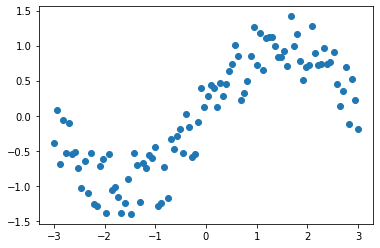

In [3]:
# from https://github.com/pkmital/tensorflow_tutorials/blob/master/python/02_linear_regression.py
# Simple tutorial for using TensorFlow to compute a linear regression.

# %% imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

# Let's create some toy data
plt.ion()
n_observations = 100
fig, ax = plt.subplots(1, 1)
xs = np.linspace(-3, 3, n_observations)
ys = np.sin(xs) + np.random.uniform(-0.5, 0.5, n_observations)
ax.scatter(xs, ys)
fig.show()
plt.draw()

# tf.placeholders for the input and output of the network. Placeholders are
# variables which we need to fill in when we are ready to compute the graph.
X = tf.placeholder(tf.float32, name="x")
Y = tf.placeholder(tf.float32)

# We will try to optimize min_(W,b) ||(X*w + b) - y||^2
# The `Variable()` constructor requires an initial value for the variable,
# which can be a `Tensor` of any type and shape. The initial value defines the
# type and shape of the variable. After construction, the type and shape of
# the variable are fixed. The value can be changed using one of the assign
# methods.
W = tf.Variable(tf.random_normal([1]), name='weight')
b = tf.Variable(tf.random_normal([1]), name='bias')
Y_pred = tf.add(tf.multiply(X, W), b, name='Y_pred')

# Loss function will measure the distance between our observations
# and predictions and average over them.
cost = tf.reduce_sum(tf.pow(Y_pred - Y, 2)) / (n_observations - 1)

# if we wanted to add regularization, we could add other terms to the cost,
# e.g. ridge regression has a parameter controlling the amount of shrinkage
# over the norm of activations. the larger the shrinkage, the more robust
# to collinearity.
# cost = tf.add(cost, tf.mul(1e-6, tf.global_norm([W])))

# Use gradient descent to optimize W,b
# Performs a single step in the negative gradient
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Saver op to save and restore all the variables
saver = tf.train.Saver()

# We create a session to use the graph
n_epochs = 1000
with tf.Session() as sess:
    # Here we tell tensorflow that we want to initialize all
    # the variables in the graph so we can use them
    sess.run(tf.global_variables_initializer())

    # Fit all training data
    prev_training_cost = 0.0
    for epoch_i in range(n_epochs):
        for (x, y) in zip(xs, ys):
            sess.run(optimizer, feed_dict={X: x, Y: y})

        training_cost = sess.run(
            cost, feed_dict={X: xs, Y: ys})
        print(training_cost)

        if epoch_i % 20 == 0:
            ax.plot(xs, Y_pred.eval(
                feed_dict={X: xs}, session=sess),
                    'k', alpha=epoch_i / n_epochs)
            fig.show()
            plt.draw()

        # Allow the training to quit if we've reached a minimum
        if np.abs(prev_training_cost - training_cost) < 0.000001:
            break
        prev_training_cost = training_cost
    print("weight ", sess.run(W), " bias ", sess.run(b))

    # Save produced model
    model_path = "/Users/boris/Projects/TensorFlowPython/models/"
    model_name = "LinearRegression"
    save_path = saver.save(sess, model_path+model_name+".ckpt")
    print("Saved model at ", save_path)
    graph_path = tf.train.write_graph(sess.graph_def, model_path, model_name+".pb", as_text=True)
    print("Saved graph at :", graph_path)

# Now freeze the graph (put variables into graph)

input_saver_def_path = ""
input_binary = False
output_node_names = "Y_pred"            # Model result node
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = model_path + 'frozen_' + model_name + '.pb'
clear_devices = True


freeze_graph.freeze_graph(graph_path, input_saver_def_path,
                          input_binary, save_path, output_node_names,
                          restore_op_name, filename_tensor_name,
                          output_frozen_graph_name, clear_devices, "")
print("Model is frozen")

# optimizing graph

input_graph_def = tf.GraphDef()
with tf.gfile.Open(output_frozen_graph_name, "r") as f:
    data = f.read()
    input_graph_def.ParseFromString(data)


output_graph_def = optimize_for_inference_lib.optimize_for_inference(
    input_graph_def,
    ["x"], # an array of the input node(s)
    ["Y_pred"], # an array of output nodes
    tf.float32.as_datatype_enum)

# Save the optimized graph

tf.train.write_graph(output_graph_def, model_path, "optimized_" + model_name + ".pb", as_text=False)
tf.train.write_graph(output_graph_def, model_path, "optimized_text_" + model_name + ".pb", as_text=True)

fig.show()
plt.waitforbuttonpress()

In [4]:
import tensorflow as tf
import numpy as np
import cv2
from os import listdir
from os.path import isfile, isdir, join
import os


def path_current():
    return os.path.dirname(os.path.realpath(__file__))


def weight_variable(shape):
    with tf.name_scope("weight"):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)


def bias_variable(shape):
    with tf.name_scope("bias"):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)


def conv2d(input, filter):
    return tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(input):
    return tf.nn.max_pool(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    flatten_image = image.ravel()
    normalized_image = flatten_image / 255
    return np.float32(normalized_image)


def load_dataset_hot_it(path, subfolder):
    my_path = join(path, subfolder)
    dirs = [f for f in listdir(my_path) if isdir(join(my_path, f))]

    data = np.empty(shape=[0, 32*32*1], dtype=np.float32)
    labels = np.empty(shape=[0, len(dirs)], dtype=np.float32)
    length = 0

    for dir in dirs:
        label, label_num = os.path.splitext(dir)
        dir_path = join(my_path, dir)
        files = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]
        for file in files:
            _, extension = os.path.splitext(file)
            if extension != '.png':
                continue
            features = load_image(join(dir_path, file))
            data = np.vstack([data, features])

            index = int(label_num[1:])
            label_temp = np.zeros((1, len(dirs)))
            label_temp[0][index] = 1
            labels = np.vstack([labels, label_temp])

            length += 1

    return data, labels, length


def freeze(checkpoint_path):
    with tf.Session() as sess:
        # First let's load meta graph and restore weights
        saver = tf.train.import_meta_graph(checkpoint_path + '.meta')
        saver.restore(sess, checkpoint_path)

        # Get the input and output tensors needed for toco
        input_tensor = sess.graph.get_tensor_by_name("input_tensor:0")
        input_tensor.set_shape([1, 1024])
        out_tensor = sess.graph.get_tensor_by_name("softmax_tensor:0")
        out_tensor.set_shape([1, 2])

        # Pass the output tensor and freeze graph
        frozen_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, sess.graph_def, output_node_names=["softmax_tensor"])

    tflite_model = tf.contrib.lite.toco_convert(frozen_graph_def, [input_tensor], [out_tensor])
    open("model.tflite", "wb").write(tflite_model)
    print("Frozen model saved")


def define_and_train():

    image_size = 32
    classes = 2
    input_layer_name = "input_tensor"
    output_layer_name = "softmax_tensor"

    train_dir = "tmp"
    learning_rate = 0.01
    batch_size = 32
    train_steps = 3000
    logging_step = 200
    checkpoint_step = 500

    # Define graph
    ############################################################

    input_layer = tf.placeholder(tf.float32, shape=[None, image_size * image_size], name=input_layer_name)
    input_image = tf.reshape(input_layer, shape=[-1, image_size, image_size, 1])

    # 1 Convolution layer
    conv1_w = weight_variable([5, 5, 1, 32])
    conv1_b = bias_variable([32])
    conv1 = tf.nn.relu(conv2d(input_image, conv1_w) + conv1_b)
    pool1 = max_pool_2x2(conv1)

    # 2 Convolution layer
    conv2_w = weight_variable([5, 5, 32, 64])
    conv2_b = bias_variable([64])
    conv2 = tf.nn.relu(conv2d(pool1, conv2_w) + conv2_b)
    pool2 = max_pool_2x2(conv2)

    # Flatten
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])

    # 3 Fully connected layer
    full_layer1_w = weight_variable([8 * 8 * 64, 1024])
    full_layer1_b = bias_variable([1024])
    full_layer1 = tf.nn.relu(tf.matmul(pool2_flat, full_layer1_w) + full_layer1_b)

    # 4 Fully connected layer
    full_layer2_w = weight_variable([1024, classes])
    full_layer2_b = bias_variable([classes])
    full_layer2 = tf.matmul(full_layer1, full_layer2_w) + full_layer2_b

    # Output
    output = tf.nn.softmax(full_layer2, name=output_layer_name)  # softmax output
    pred = tf.argmax(output, axis=1)  # predictions

    # Placeholders used for training
    output_true = tf.placeholder(tf.float32, shape=[None, classes])
    pred_true = tf.argmax(output_true, axis=1)


    # Calculate loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=output_true, logits=full_layer2))
    # Configure training operation
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    # Add evaluation metrics
    accuracy = tf.reduce_mean(tf.cast(tf.equal(pred, pred_true), tf.float32))


    # Training
    ############################################################

    train_data, train_labels, train_length = load_dataset_hot_it(path_current(), "dataset/train")
    eval_data, eval_labels, _ = load_dataset_hot_it(path_current(), "dataset/test")

    # Initialize variables (assign default values..)
    init = tf.global_variables_initializer()
    # Initialize saver
    saver = tf.train.Saver()

    # Create a summary to monitor cost tensor
    tf.summary.scalar("loss", loss)
    # Create a summary to monitor accuracy tensor
    tf.summary.scalar("accuracy", accuracy)
    # Merge all summaries into a single op
    merged_summary_op = tf.summary.merge_all()

    with tf.Session() as session:
        session.run(init)
        summary_writer = tf.summary.FileWriter(train_dir, graph=tf.get_default_graph())

        for step in range(train_steps+1):
            # Get random batch
            idx = np.random.randint(train_length, size=batch_size)
            batchX = train_data[idx, :]
            batchY = train_labels[idx, :]

            # Run the optimizer
            _, train_loss, train_accuracy, summary = session.run(
                [optimizer, loss, accuracy, merged_summary_op],
                feed_dict={input_layer: batchX,
                           output_true: batchY}
            )
            # Add summary for tensorboard
            summary_writer.add_summary(summary, step)

            # Test training
            if step % logging_step == 0:
                test_loss, test_accuracy = session.run(
                    [loss, accuracy],
                    feed_dict={input_layer: eval_data,
                               output_true: eval_labels}
                )

                print("Step {0:d}: Loss = {1:.4f}, Accuracy = {2:.3f}".format(step, test_loss, test_accuracy))

            # Save checkpoint
            if step % checkpoint_step == 0:
                saver.save(session, path_current() + "/tmp/model.ckpt", global_step=step)

        print("Training finished")


def main():
    define_and_train()

    checkpoint_path = "tmp/model.ckpt-3000"
    freeze(checkpoint_path)


if __name__ == "__main__":
    main()

AttributeError: module 'tensorflow' has no attribute 'placeholder'